# Sparkify Churn Project

### Table of Contents

1. <a href="#Overview">Overview</a>
2. <a href="#Load-and-Clean-Dataset">Load and Clean Dataset</a>
3. <a href="#Exploratory-Data-Analysis">Exploratory Data Analysis </a>
    1. <a href="#Data-Preperation">Data Preperation </a>
    1. <a href="#Insights-From-Processed-Dataset">Insights From Processed Dataset</a>
4. <a href="#Feature-Engineering">Feature Engineering </a>
5. <a href="#Modeling">Modeling </a>
6. <a href="#Conclusion">Conclusion</a>
    1. <a href="#Reflection">Reflection</a>
    1. <a href="#Improvement">Improvement</a>

# Overview






Sparkify is a Music platform like <a href="https://fizy.com/">Fizy</a>. Sparkify's most important problem is Churn. Churn defines cancellation of the subscription.

In this case we are going to predict potential churner subscribers. If Sparkify detects the subscriber who will be churner, they can take actions to labeled subscribers like discount, no ads and so on.

The data provided from Sparkify Company has customer logs in the platform. Also the dataset has variables like age, gender, location. First of all we analyzed the dataset and created some features about subscribers. After Feature engineering steps we went to modelling steps and tried some ML alogrithms for predict the potential churner subscribers correctly. In the evaluation step we used F1 Score because the dataset is imbalanced. Accuracy is not a good metric for this problem.

Finally We achieved 0.82 F1 Score with Crossvalidated Random Forest Classifier. Also We prepared an <a href="https://abduygur.medium.com/churn-prediction-using-pyspark-a1f4ef0439b3">article in the medium about this project</a>



# Load and Clean Dataset
In this workspace, the file is `medium_sparkify_event_data.json` provided by Sparkify Company

## Import Libraries and Setup Environment

In [1]:
!pip install httpagentparser

import pyspark
import pandas as pd
from pyspark.sql.functions import col, udf, sum as Fsum, from_unixtime, \
    count, countDistinct, when, isnull, max as Fmax, min as Fmin, length, \
    month, datediff, first, year, concat
from pyspark.sql.types import IntegerType, FloatType, DateType, TimestampType, LongType, StringType
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


import httpagentparser
import matplotlib.pyplot as plt
import seaborn as sns
import time



import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'STORAGEURL',
    'service_id': 'API',
    'iam_service_endpoint': 'SERVICE',
    'api_key': 'TOKEN'
}

configuration_name = 'os_546af22583c84beb96dd0cca3d3dc17f_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')


from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName('Sparkify_Churn') \
    .getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json



Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20210129061231-0001
KERNEL_ID = 62d57eec-4b0c-4ff9-bc55-d761c64d1800
Processing ./.cache/pip/wheels/f9/d4/cd/cf12d0bb9578ac4fb9457c586dd2fe5a7430942968e638bc8c/httpagentparser-1.9.1-py2.py3-none-any.whl


In [2]:
#Some Options about pandas and matplotlib
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None) 

import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rc('axes', labelsize=20, titlesize=25)
matplotlib.rc('figure', titlesize=25)

#Disable Warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
def check_nulls(dataframe):
    '''
    Check null values and return the null values in pandas Dataframe
    
    INPUT: Spark Dataframe
    OUTPUT: Null values
    
    '''
    # Create pandas dataframe
    nulls_check = pd.DataFrame(dataframe.select([count(when(isnull(c), c)).alias(c) for c in dataframe.columns]).collect(),
                               columns = dataframe.columns).transpose()
    nulls_check.columns = ['Null Values']
    return nulls_check

def grouped_session(df, agg_col='sessionId', group_col='yearmonth', col_suffixes='_monthly'):
    
    '''
    Group the dataframe by UserId and count distinct values of agg_col, gives the name with col_suffixes
    
    INPUT: Spark Dataframe, Aggregate Column, Group Column, Column Suffixes
    OUTPUT: UserId based groupped and aggregated column
    '''
    
    #Group dataframe by UserId and group_col(default:yearmonth) and aggregate by CountDistinct by column(default:sessionId)
    #Change the column name using col_suffixes arguement 
    session = df.groupBy('userId',group_col).agg(countDistinct(agg_col).alias('session_count'))
    session = session.groupBy('userId').avg('session_count') \
        .withColumnRenamed('avg(session_count)','session_count'+col_suffixes)
    
    return session

def grouped_session_length(df, agg_col='time', group_col='yearmonth', col_suffixes='_monthly'):
    
    '''
    Group the dataframe by UserId and sessionId and take difference max and min of agg_col, gives the name with col_suffixes.
    It is using for calculating average session length by user
    
    INPUT: Spark Dataframe, Aggregate Column, Group Column, Column Suffixes
    OUTPUT: UserId based groupped and aggregated column
    '''
    #Groups the userId, sessionId and group_col(default:yearmonth)
    session_length = df.groupBy('userId','sessionId',group_col) \
        .agg(Fmin(agg_col).alias('start_time'), Fmax(agg_col).alias('end_time'))
    #Calculate session durations
    session_length = session_length.withColumn('duration',(col('end_time') \
                                                           .cast(LongType()) - col('start_time').cast(LongType())))
    #Calculate average session duration by user and group_col(default:yearmonth)
    session_length = session_length.groupBy('userId',group_col).avg('duration') \
        .withColumnRenamed('avg(duration)','avg_duration')
    #Calculate average session duration by user distinctly
    session_length = session_length.groupBy('userId').avg('avg_duration') \
        .withColumnRenamed('avg(avg_duration)','avg_duration')
    session_length = session_length.withColumn('avg_duration'+col_suffixes,col('avg_duration')/3600)
    session_length = session_length.drop('avg_duration')
    
    return session_length

def category_freq(df,cat_col,suffix):
    
    """
    Take most frequent value in category column by UserId
    
    INPUT: Spark Dataframe, Categorical Column, suffix
    OUTPUT: Most frequent value by UserId
    
    """
    #group userId and categorical column and count it
    most_frequent = df.groupBy('userId',cat_col).count()
    
    #Get the most frequent categorical column for every individual userId
    most_frequent = most_frequent.orderBy('count',ascending=False).groupBy('userId') \
    .agg(first(cat_col).alias('most_frequent'+suffix))
    
    return most_frequent


def groupped_dfs(df_pandas,col,target='target'):
    
    """
    Calculate the proportion of the categorical column values and their counts for graphs
    
    INPUT: Pandas Dataframe, categorical column, Target Column
    OUTPUT: Value counts groupped by UserId and the proportion of the value
    
    """
    #Take the categorical columns value_counts()
    counts = df_pandas[col].value_counts()
    #Calculate the proportion
    props = df_pandas.groupby([col]).target.value_counts(normalize=True)*100
    props = props.rename_axis([col+'_',target+'_']).reset_index()
    props.columns = [col+'_',target+'_','Proportion']
    
    return counts,props

def prepare_data(features_df):
    """
    Transform features to vectors with pipeline for modelling
    
    INPUT: Prepared Dataframe
    OUTPUT: Dataframe with input vectors
    """
    #Empty list which will be filled with numeric columns of Spark Dataframe
    num_cols = []
    
    #take all non-string type field names
    for field in features_df.schema.fields :
        if field.dataType!=StringType():
            num_cols.append(field.name)
    
    #remove target variable which is churn or not
    num_cols.remove('target')
    
    #Index the categorical variables with StringIndexer
    print("Indexer Process...")
    location_indexer = StringIndexer(inputCol='location', outputCol='location_index')
    gender_indexer = StringIndexer(inputCol='gender', outputCol='gender_index')
    level_indexer = StringIndexer(inputCol='current_charging', outputCol='level_index')
    browser_indexer = StringIndexer(inputCol='most_frequent_browser', outputCol='browser_index')
    os_indexer = StringIndexer(inputCol='most_frequent_os', outputCol='os_index')
    print("Success!")
    
    #Encode the Output of the Indexers with OneHotEncoder
    print("OneHot Encoder Process...")
    onehot_encoder = OneHotEncoder(inputCols=["gender_index","level_index","browser_index","os_index"],
                                   outputCols=[ "gender_vec","level_vec","browser_vec","os_vec"])
    print("Success!")
    
    #Assemble all variables to one single vector with VectorAssembler
    print("Assembler Process...")
    assembler = VectorAssembler(inputCols=num_cols+["gender_vec","level_vec","browser_vec","os_vec"],
                                outputCol='features')
    
    print("Columns: {} assembled to the features column".format(num_cols+["gender_vec","level_vec","browser_vec","os_vec"]))
    
    print("Success!")
    
    #Create pipeline which is index the categorical columns, encode them and assemble all variables to assembler
    process_pipeline = Pipeline(stages=[location_indexer,gender_indexer,level_indexer,browser_indexer,os_indexer,
                                        onehot_encoder,assembler])
    #fit the dataframe to pipeline and transform şt
    print("Pipeline fit...")
    model_df = process_pipeline.fit(features_df).transform(features_df)
    print("Success!")
    model_df = model_df.select("features","target")
    return model_df


def rf_tuning(train, test, numTrees=[20,50,100], maxDepth=[5,10,20] ):
    """
    Tunes the RandomForestClassifier with given numTrees and maxDepth arguements
    
    INPUT: train set, test set, list of numTrees, list of maxDepth
    OUTPUT: bestmodel after tuning
    """
    #Model
    clf = RandomForestClassifier(labelCol="target")
    
    #Grid for parameter tuning
    paramGrid = ParamGridBuilder() \
        .addGrid(clf.numTrees, numTrees) \
        .addGrid(clf.maxDepth, maxDepth) \
        .build()   
    
    #3 Fold Cross Validation
    crossval = CrossValidator(estimator = Pipeline(stages=[clf]),
                         estimatorParamMaps = paramGrid,
                         evaluator = MulticlassClassificationEvaluator(metricName='f1',labelCol="target"),
                         numFolds = 3)

    cvModel = crossval.fit(train)
    predictions = cvModel.transform(test)
    
    #Model Evaluation
    model_evaluator= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='target')
       
    
    f1_score = model_evaluator.evaluate(predictions.select('target','prediction'),{model_evaluator.metricName: 'f1'})
    acc_score = model_evaluator.evaluate(predictions.select('target','prediction'),{model_evaluator.metricName: 'accuracy'})
    pre_score = model_evaluator.evaluate(predictions.select('target','prediction'),{model_evaluator.metricName: 'precisionByLabel'})
    rec_score = model_evaluator.evaluate(predictions.select('target','prediction'),{model_evaluator.metricName: 'recallByLabel'})
    
    print("RESULTS:")
    print("*"*10)
    print('The F1 score is {}'.format(f1_score))
    print('The Accuracy score is {}'.format(acc_score))
    print('The Precision score is {}'.format(pre_score))
    print('The Recall score is {}'.format(rec_score))
    print("*"*10)
    #Take the best Model
    bestModel = cvModel.bestModel
    
    return bestModel
    



In [4]:
#Read the dataframe
df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkifychurn-donotdelete-pr-b0enq8ijgb8vvt'))
df.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

# Exploratory Data Analysis

In this part I analyzed raw data and I want to show the dataset details

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
#counts
df.count(), len(df.columns), df.select('userId').distinct().count()

(543705, 18, 449)

Dataset including 543K Rows, 18 Columns and 449 Distinct customers

In [7]:
#Type of auths
auths = df.select('auth').distinct().collect()
print("\n".join(str(auths[i][0]) for i in range(len(auths))))

Logged Out
Cancelled
Guest
Logged In


In [8]:
#type of levels
levels = df.select('level').distinct().collect()
print("\n".join(str(levels[i][0]) for i in range(len(levels))))

free
paid


In [9]:
#Genders
genders = df.select('gender').distinct().collect()
print("\n".join(str(genders[i][0]) for i in range(len(genders))))

F
None
M


In [10]:
#Show the max log time and min log time
df.agg(Fmax(from_unixtime(col('ts')/1000).cast(DateType()))).collect(), df.agg(Fmin(from_unixtime(col('ts')/1000).cast(DateType()))).collect() 

([Row(max(CAST(from_unixtime((ts / 1000), yyyy-MM-dd HH:mm:ss) AS DATE))=datetime.date(2018, 12, 1))],
 [Row(min(CAST(from_unixtime((ts / 1000), yyyy-MM-dd HH:mm:ss) AS DATE))=datetime.date(2018, 10, 1))])

From October'18 to December'18 (Events in 2 Months)

In [11]:
#Check null values
check_nulls(df)

,Null Values
artist,110828
auth,0
firstName,15700
gender,15700
itemInSession,0
lastName,15700
length,110828
level,0
location,15700
method,0


As you can see in the null values table. There is some patterns.

- We have distinct 2 values in null table which are 110828 and 15700
- artist, length and song have a pattern and demographics info has another 

In [12]:
df.where('firstName is null').show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          186|    null|  null| paid|    null|   GET| Home|        null|      178|null|   200|1538352148000|     null|      |
|  null|Logged Out|     null|  null|          187|    null|  null| paid|    null|   GET| Home|        null|      178|null|   200|1538352151000|     null|      |
|  null|Logged Out|     null|  null|          188|    null|  null| paid|    null|   GET| Home|        null|      178|null|   200|1538352168000|     null|      |
|  null|Logged Out|     null|  nul

userId has some None values, but not nulls that means we have no information about user

In [13]:
df.where('firstName is null').select('userId','auth').groupby(['userId','auth']).count().show()

+------+----------+-----+
|userId|      auth|count|
+------+----------+-----+
|      |     Guest|   94|
|      |Logged Out|15606|
+------+----------+-----+



There is no demographic information in auth with Guest and logged Out. Because of logging off the information about users disappear in the current system

In [14]:
df.select('auth').groupby(['auth']).count().show()

+----------+------+
|      auth| count|
+----------+------+
|Logged Out| 15606|
| Cancelled|    99|
|     Guest|    94|
| Logged In|527906|
+----------+------+



In [15]:
df.where('song is null').select('auth','level','method','page') \
    .groupby(['auth','level','method','page']).count() \
    .orderBy(col('count').desc()).show(20)

+----------+-----+------+---------------+-----+
|      auth|level|method|           page|count|
+----------+-----+------+---------------+-----+
| Logged In| paid|   PUT|      Thumbs Up|19504|
| Logged In| paid|   GET|           Home|13956|
| Logged In| paid|   PUT|Add to Playlist|10033|
| Logged In| free|   GET|    Roll Advert| 7337|
| Logged In| paid|   PUT|     Add Friend| 6341|
|Logged Out| paid|   GET|           Home| 5513|
| Logged In| free|   GET|           Home| 5133|
| Logged In| free|   PUT|      Thumbs Up| 4322|
| Logged In| paid|   PUT|         Logout| 4184|
|Logged Out| paid|   PUT|          Login| 4171|
| Logged In| paid|   GET|      Downgrade| 3811|
| Logged In| paid|   PUT|    Thumbs Down| 3771|
|Logged Out| free|   GET|           Home| 2769|
| Logged In| free|   PUT|Add to Playlist| 2316|
| Logged In| paid|   GET|       Settings| 2240|
| Logged In| paid|   GET|           Help| 2076|
|Logged Out| free|   PUT|          Login| 1840|
| Logged In| free|   PUT|         Logout

- auth has 2 distinct values already
- level has 2 distinct values already
- method has 2 distinct values already

Let me check page attribute

In [16]:
all_pages = pd.DataFrame(df.select('page').distinct().collect())
all_pages.columns = ['page_all']

songnull_pages = pd.DataFrame(df.where('song is null').select('page').distinct().collect())
songnull_pages.columns = ['page_songnull']

set_diff = set(all_pages['page_all']) - set(songnull_pages['page_songnull'])

print("-"*100)
print("All Pages\n")
print("\n".join(page for page in all_pages['page_all']))
print("-"*100)
print("Pages when song is null\n")
print("\n".join(page for page in songnull_pages['page_songnull']))
print("-"*100)
print("When song is null, {} pages can not be seen".format(set_diff))

----------------------------------------------------------------------------------------------------
All Pages

Cancel
Submit Downgrade
Thumbs Down
Home
Downgrade
Roll Advert
Logout
Save Settings
Cancellation Confirmation
About
Submit Registration
Settings
Login
Register
Add to Playlist
Add Friend
NextSong
Thumbs Up
Help
Upgrade
Error
Submit Upgrade
----------------------------------------------------------------------------------------------------
Pages when song is null

Cancel
Submit Downgrade
Thumbs Down
Home
Downgrade
Roll Advert
Logout
Save Settings
Cancellation Confirmation
About
Submit Registration
Settings
Login
Register
Add to Playlist
Add Friend
Thumbs Up
Help
Upgrade
Error
Submit Upgrade
----------------------------------------------------------------------------------------------------
When song is null, {'NextSong'} pages can not be seen


NextSong page doesn't have song information so song values are nulls in NextSong Page

In [17]:
#None type userId's
df.filter(df['userId'] != '').show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|       Martin Orford|Logged In|   Joseph|     M|           20|  Morales|597.55057| free|  Corpus Christi, TX|   PUT|       NextSong|1532063507000|      292|       Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
|   John Brown's Body|Logged In|   Sawyer|     M|           74|   Larson|380.21179| free

## Data Preperation
In this part we created some features related to the customers. After feature engineering steps there will be small part of visualisation part for understand the data better.

In [18]:
#Function for users os information
udf_os = udf(lambda x: httpagentparser.simple_detect(x)[0].split(' ')[0], StringType())
#Function for users browser information
udf_browser =  udf(lambda x: httpagentparser.simple_detect(x)[1].split(' ')[0], StringType())
#Function for users Location
udf_location = udf(lambda x: x.split(',')[1], StringType())

In [19]:
# Create target variable using Cancellation Confirmation and  Cancel pages
# If system logged one of them then flag them with churn othwerwise not-churn


label = df.withColumn('target', when((col('page').isin(['Cancellation Confirmation','Cancel'])) | \
                                        (col('auth')=='Cancelled'),1).otherwise(0))
label = label.groupby('userId').agg(Fsum('target').alias('target'))
label = label.withColumn('target', when(col('target')>0,1).otherwise(0))


In [20]:
#Users Os, Browser and location informations Using UDF's
df = df.withColumn('os', udf_os('userAgent'))
df = df.withColumn('browser', udf_browser('userAgent'))
df = df.withColumn('location', udf_location('location'))

In [21]:
#Convert unixtime to Standard Time
df = df.withColumn('time',from_unixtime(col('ts')/1000).cast(TimestampType()))
#Convert unixtime to Standard Date
df = df.withColumn('date',from_unixtime(col('ts')/1000).cast(DateType()))
#Take month from date
df = df.withColumn('month',month(col('date')))
#Take year from date
df = df.withColumn('year',year(col('date')))
#Create yearmonth(YYYYMM) using year and month columns
df = df.withColumn('yearmonth', concat(col('year'),col('month')))
#Users registiration date
df = df.withColumn('first_date',from_unixtime(col('registration')/1000).cast(DateType()))


In [22]:
#Clear the userId with None Variable and Logged Out auth 
df = df.filter(df['userId'] != '')
df = df.withColumn('userId', col('userId').cast(LongType()))
df = df.filter(df['auth'] != 'Logged Out')

#Dropna values if any
df = df.dropna(how='any', subset=['userId','sessionId'])


In [23]:
# Last log date of each user
last_date = df.groupBy('userId').agg(Fmax('date').alias('last_date'))

# Last Charging Method for every users(Paid or Free)
current_charging = df.orderBy('ts', ascending=False).groupBy('userId') \
    .agg(first('level') \
    .alias('current_charging'))

#Create average and maximum length attributes for each user
length_mean = df.groupBy('userId').avg('length').withColumnRenamed('avg(length)','avg_length')
length_max = df.groupBy('userId').agg(Fmax('length').alias('max_length'))


In [24]:
#Calculate page logs in monthly and daily averages
#Create distinct pages and remove churn pages
distinct_pages = [i.page for i in df.select('page').distinct().collect()]
distinct_pages.remove('Cancellation Confirmation')
distinct_pages.remove('Cancel')

#Group user and Date and calculate visit count of each pages
exprs = {x: 'avg' for x in distinct_pages}
event_day = df.groupBy('userId','date').pivot('page').count()
event_day = event_day.groupBy('userId').agg(exprs).fillna(0)

#Group user and Month and calculate visit count of each pages
event_month = df.groupBy('userId','yearmonth').pivot('page').count()
event_month = event_month.groupBy('userId').agg(exprs).fillna(0)
for column in distinct_pages:
    event_day = event_day.withColumnRenamed('avg({})'.format(column),'event_{}_daily_avg'.format(column))
    event_month = event_month.withColumnRenamed('avg({})'.format(column),'event_{}_monthly_avg'.format(column))




In [25]:
#Calculate users item count in each session
item_per_session = df.groupBy('userId','sessionId').agg(Fmax('itemInSession').alias('max_item_cnt'))
item_per_session = item_per_session.groupBy('userId').avg('max_item_cnt') \
    .withColumnRenamed('avg(max_item_cnt)','avg_item_per_session')


In [26]:
#Calculate daily and monthly average session counts
monthly_session = grouped_session(df)
daily_session = grouped_session(df,group_col='date',col_suffixes='_daily')

In [27]:
#Calculate daily and monthly average session length
session_length_monthly = grouped_session_length(df)
session_length_daily = grouped_session_length(df, group_col='date',col_suffixes='_daily')

In [28]:
#Users most frequent os and browser
most_frequent_os = category_freq(df,'os','_os')
most_frequent_browser = category_freq(df,'browser','_browser')

In [29]:
#Join all created features
df_ready = df.select('userId','location','gender','first_date').distinct() \
    .join(session_length_monthly,on='userId') \
    .join(session_length_daily,on='userId') \
    .join(monthly_session,on='userId') \
    .join(daily_session,on='userId') \
    .join(item_per_session,on='userId') \
    .join(event_month,on='userId') \
    .join(event_day,on='userId') \
    .join(length_mean,on='userId') \
    .join(length_max,on='userId') \
    .join(current_charging,on='userId') \
    .join(last_date,on='userId') \
    .join(label,on='userId') \
    .join(most_frequent_browser,on='userId') \
    .join(most_frequent_os,on='userId')

#Calculate Tenure
df_ready = df_ready.withColumn('tenure_days', datediff(col('last_date'),col('first_date')))

#Drop unnecessary columns
df_ready = df_ready.drop('userId','first_date','last_date')

## Insights From Processed Dataset

In [30]:
df_ready.printSchema()

root
 |-- location: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- avg_duration_monthly: double (nullable = true)
 |-- avg_duration_daily: double (nullable = true)
 |-- session_count_monthly: double (nullable = true)
 |-- session_count_daily: double (nullable = true)
 |-- avg_item_per_session: double (nullable = true)
 |-- event_Settings_monthly_avg: double (nullable = false)
 |-- event_Add Friend_monthly_avg: double (nullable = false)
 |-- event_Thumbs Down_monthly_avg: double (nullable = false)
 |-- event_Downgrade_monthly_avg: double (nullable = false)
 |-- event_Submit Upgrade_monthly_avg: double (nullable = false)
 |-- event_Roll Advert_monthly_avg: double (nullable = false)
 |-- event_NextSong_monthly_avg: double (nullable = false)
 |-- event_Error_monthly_avg: double (nullable = false)
 |-- event_About_monthly_avg: double (nullable = false)
 |-- event_Upgrade_monthly_avg: double (nullable = false)
 |-- event_Add to Playlist_monthly_avg: double (nullable = fa

In [31]:
#Create Pandas Dataframe for visualisation
df_pandas_ready = df_ready.toPandas()

In [32]:
df_pandas_ready.head()

,location,gender,avg_duration_monthly,avg_duration_daily,session_count_monthly,session_count_daily,avg_item_per_session,event_Settings_monthly_avg,event_Add Friend_monthly_avg,event_Thumbs Down_monthly_avg,event_Downgrade_monthly_avg,event_Submit Upgrade_monthly_avg,event_Roll Advert_monthly_avg,event_NextSong_monthly_avg,event_Error_monthly_avg,event_About_monthly_avg,event_Upgrade_monthly_avg,event_Add to Playlist_monthly_avg,event_Home_monthly_avg,event_Thumbs Up_monthly_avg,event_Logout_monthly_avg,event_Submit Downgrade_monthly_avg,event_Save Settings_monthly_avg,event_Help_monthly_avg,event_Settings_daily_avg,event_Add Friend_daily_avg,event_Thumbs Down_daily_avg,event_Downgrade_daily_avg,event_Submit Upgrade_daily_avg,event_Roll Advert_daily_avg,event_NextSong_daily_avg,event_Error_daily_avg,event_About_daily_avg,event_Upgrade_daily_avg,event_Add to Playlist_daily_avg,event_Home_daily_avg,event_Thumbs Up_daily_avg,event_Logout_daily_avg,event_Submit Downgrade_daily_avg,event_Save Settings_daily_avg,event_Help_daily_avg,avg_length,max_length,current_charging,target,most_frequent_browser,most_frequent_os,tenure_days
0,CA,M,5.398750,3.571204,2.0,1.000000,85.500000,1.0,8.0,0.0,0.0,1.0,0.0,129.0,0.0,1.0,2.0,4.0,10.0,7.0,3.0,0.0,0.0,0.0,1.000000,2.666667,0.000000,0.000000,1.0,0.000000,43.000000,0.00,1.00,2.000000,2.000000,3.333333,3.500000,3.000000,0.0,0.0,0.000000,237.179840,655.77751,paid,0,Firefox,Windows,46
1,CA,M,3.512280,3.037352,19.5,1.285714,61.153846,6.5,20.0,8.5,4.5,1.0,36.5,953.5,5.0,2.5,2.0,24.0,45.0,45.0,15.5,1.0,1.0,7.0,1.083333,2.857143,1.416667,1.125000,1.0,3.842105,54.485714,1.25,1.25,1.333333,2.285714,3.214286,3.461538,1.722222,1.0,1.0,1.555556,248.499650,2520.99873,free,0,Safari,MacOS,76
2,FL,M,1.473993,1.120486,6.0,1.083333,28.666667,0.0,3.0,1.0,0.0,0.0,18.5,124.5,0.0,0.0,2.0,3.0,9.5,4.5,4.5,0.0,0.0,1.5,0.000000,1.500000,1.000000,0.000000,0.0,4.625000,24.900000,0.00,0.00,2.000000,3.000000,1.900000,1.285714,1.125000,0.0,0.0,1.500000,247.345358,562.20689,free,0,Chrome,Windows,182
3,NH,M,4.636167,4.166661,13.5,1.320000,81.185185,7.0,18.0,7.5,10.5,1.0,14.0,891.0,1.0,3.0,3.5,23.0,38.0,44.5,12.0,1.0,1.5,4.0,2.000000,2.400000,1.875000,1.909091,1.0,3.111111,74.250000,1.00,1.00,1.400000,3.538462,3.304348,5.933333,1.500000,1.0,1.0,1.600000,248.498211,978.44200,paid,0,Firefox,Linux,71
4,WA,M,1.733611,2.147037,1.5,1.000000,40.000000,0.0,0.0,2.0,0.0,0.0,7.0,49.5,0.0,0.0,1.0,2.0,1.5,2.5,1.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.0,3.500000,33.000000,0.00,0.00,1.000000,2.000000,1.000000,2.500000,1.000000,0.0,0.0,0.000000,240.130818,472.89424,free,0,Safari,MacOS,72


In [33]:
#Calculate churn rate in all dataset
churn_props = df_pandas_ready['target'].value_counts(normalize=True)*100


In [34]:
#Calculate proportion and counts for each categorical variables
os_count, os_prop = groupped_dfs(df_pandas_ready,'most_frequent_os')
browser_count, browser_prop = groupped_dfs(df_pandas_ready,'most_frequent_browser')
gender_count, gender_prop = groupped_dfs(df_pandas_ready,'gender')
location_count, location_prop = groupped_dfs(df_pandas_ready,'location')
level_count, level_prop = groupped_dfs(df_pandas_ready,'current_charging')

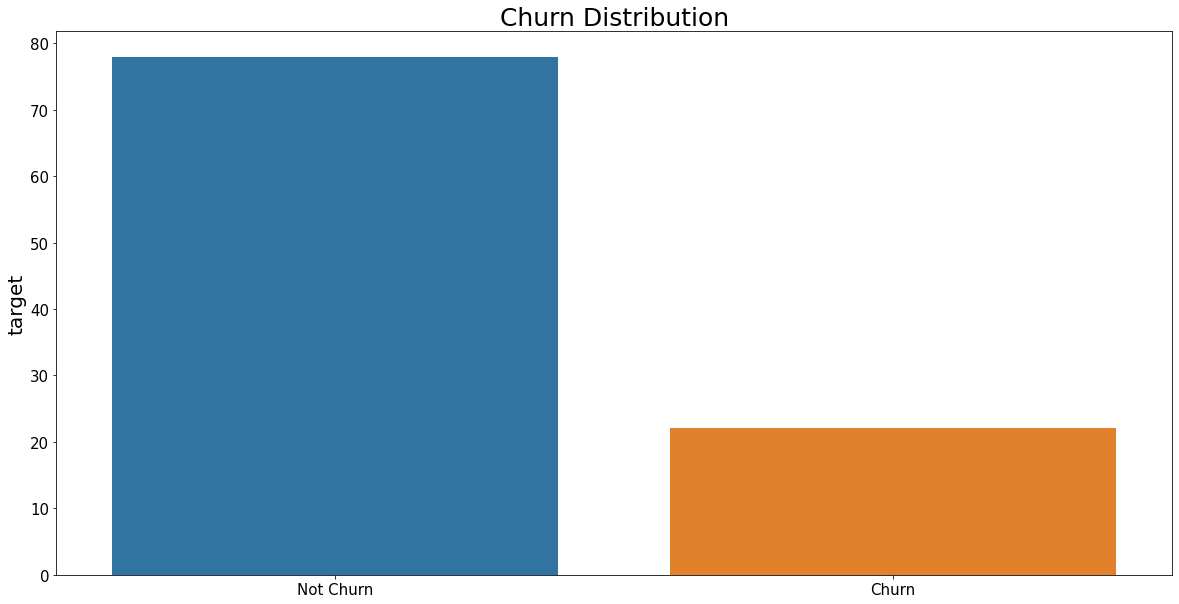

In [35]:
plt.figure(figsize=(20,10))
plt.title("Churn Distribution")
sns.barplot(x=['Not Churn','Churn'], y=churn_props);

Churn Rate is around 20%. It is imbalanced data. In this case it is hard to predict potential churners and we know that we won't use accuracy metric for prediction. It is good insight for this case



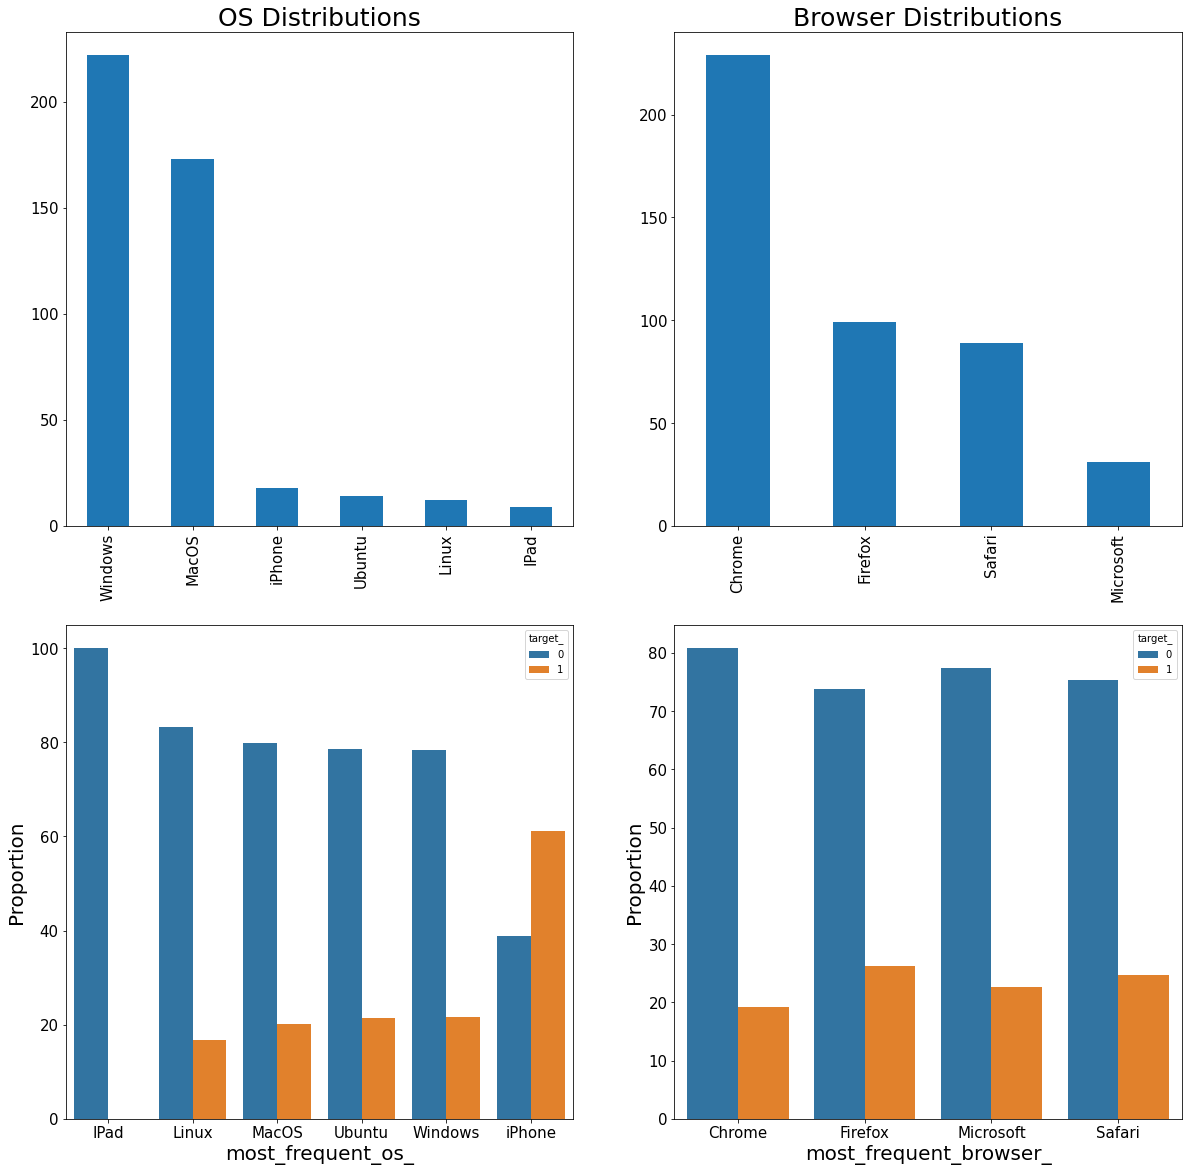

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(20,20))

ax[0][0].set_title("OS Distributions")
ax[0][1].set_title("Browser Distributions")


os_count.plot(kind='bar', ax=ax[0][0]);
browser_count.plot(kind='bar', ax=ax[0][1]);

sns.barplot(x='most_frequent_os_',y='Proportion', hue='target_', data=os_prop, ax=ax[1][0]);
sns.barplot(x='most_frequent_browser_',y='Proportion', hue='target_', data=browser_prop, ax= ax[1][1]);

- Most of users use windows for os and most of users use Chrome web browser
- Ipad has 0 churn rate but proportion of Ipad users are very low
- Linux, MacOs, Ubuntu and Windows users has nearly 20% churn rate but iPhone users 60% churn rate. Maybe there is a problem with user experience.
- Users who are using Firefox web browser churn rate is nearly 30%

Both OS and Browser attributes can be good predictor for churn

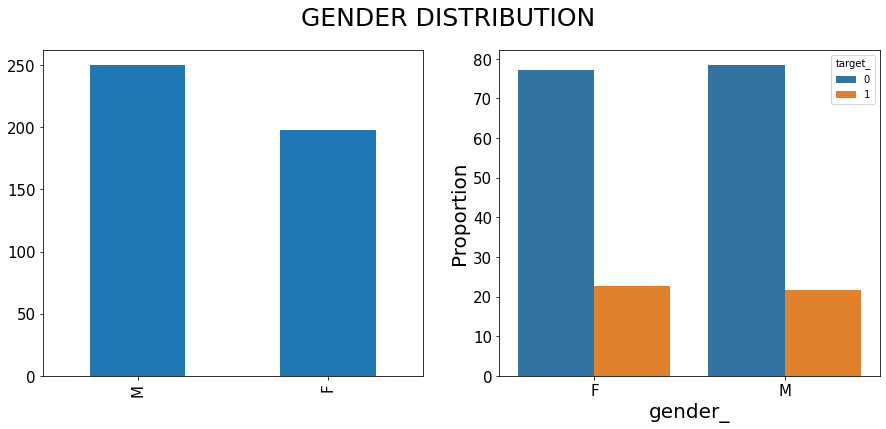

In [37]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
fig.suptitle("GENDER DISTRIBUTION")
gender_count.plot(kind='bar', ax=ax[0]);

sns.barplot(x='gender_',y='Proportion', hue='target_', data=gender_prop, ax=ax[1]);

There is no significant churn rate difference in Gender

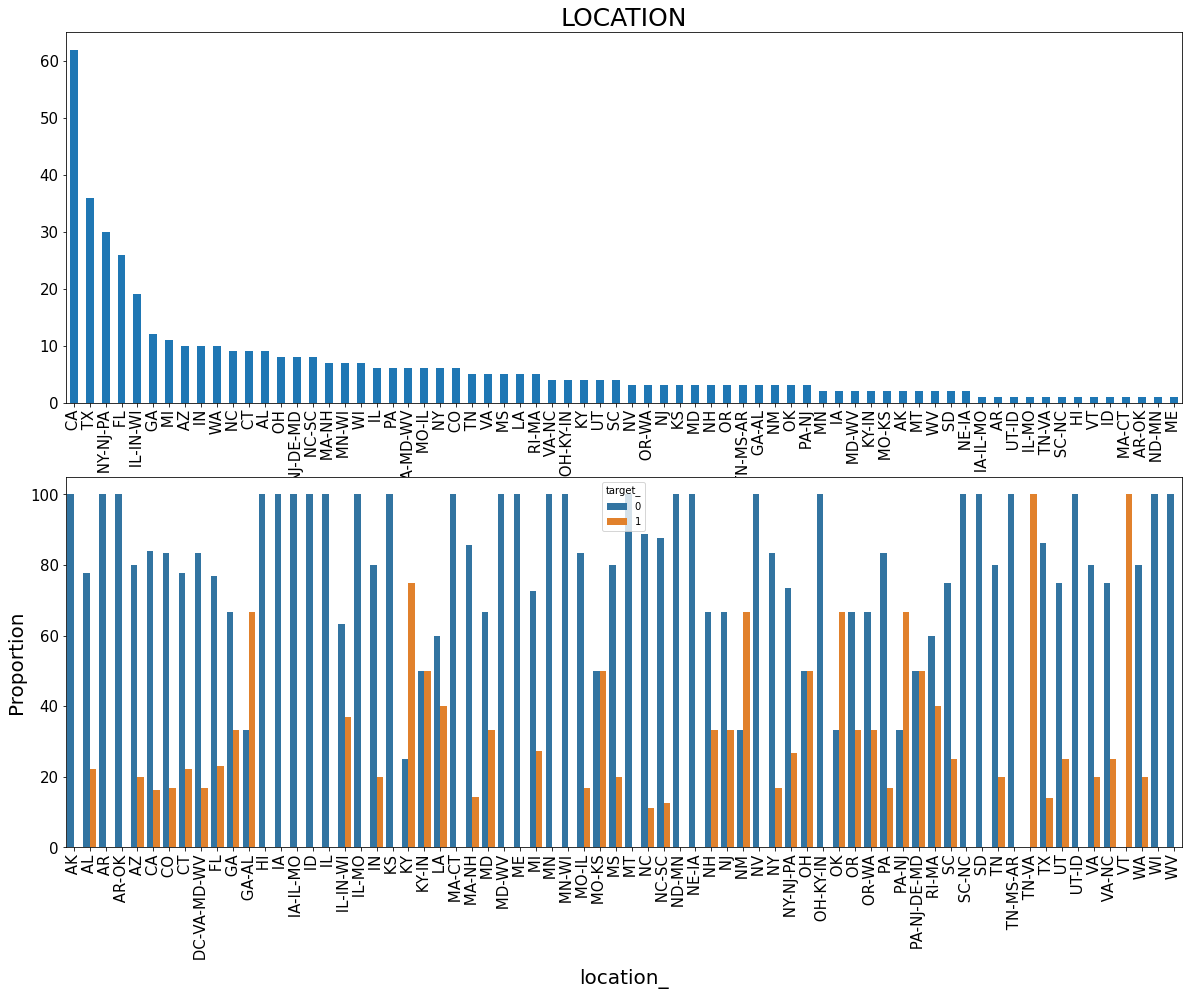

In [38]:
fig, ax = plt.subplots(2,1,figsize=(20,15))
ax[0].set_title("LOCATION")
location_count.plot(kind='bar', ax=ax[0]);

sns.barplot(x='location_',y='Proportion', hue='target_', data=location_prop, ax=ax[1])

ax[1].tick_params(axis='x', rotation=90);

Location can be good estimator because some location has nearly 100% churn rate. So keep this attribute in model data

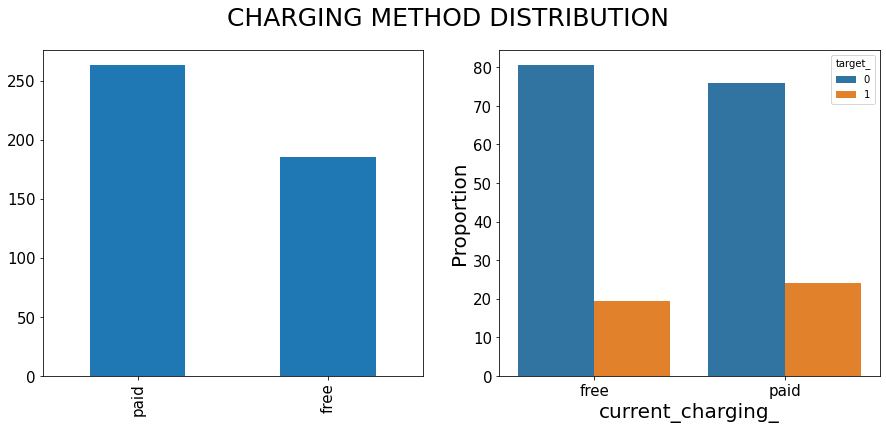

In [39]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
fig.suptitle("CHARGING METHOD DISTRIBUTION")
level_count.plot(kind='bar', ax=ax[0]);

sns.barplot(x='current_charging_',y='Proportion', hue='target_', data=level_prop, ax=ax[1]);

It is interesting that both paid and free customers have nearly same churn rate. I expected that paid customers have high churn rate but it is not

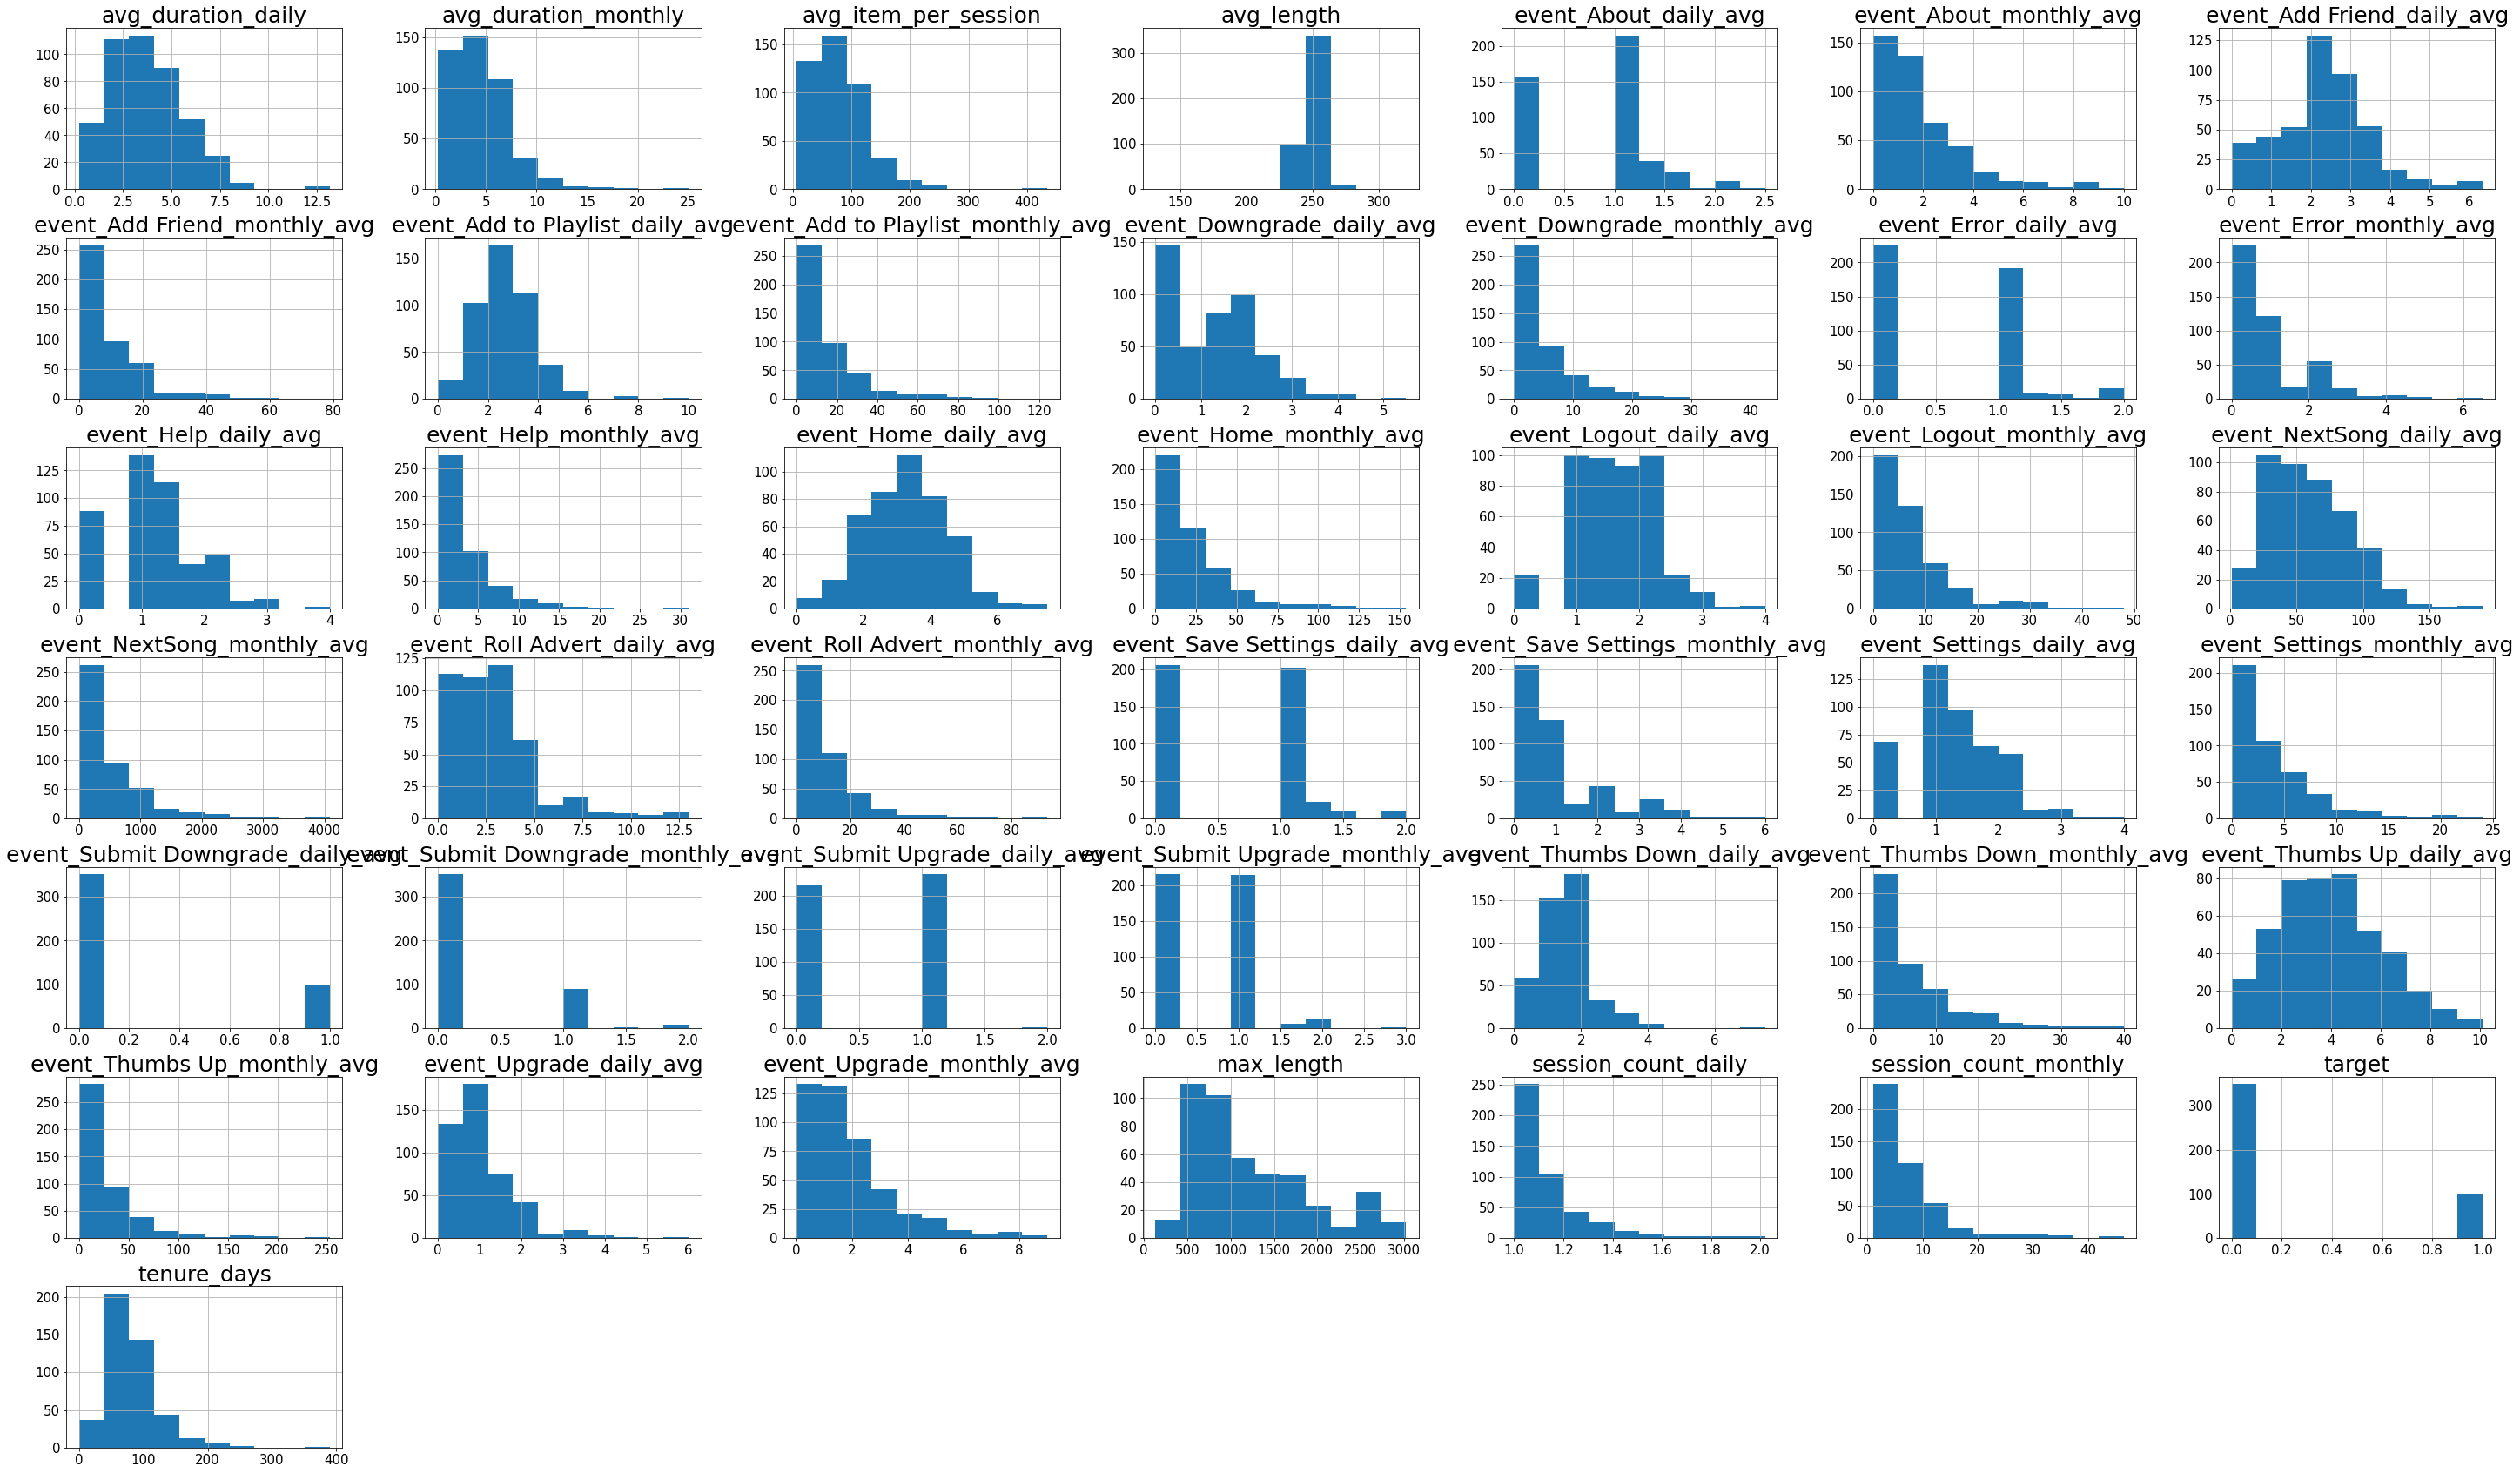

In [40]:
fig = plt.figure(figsize=(50,30))
ax = fig.gca()
h = df_pandas_ready.hist(ax=ax);

The graph above shows the all datasets distribution. Some of them highly skewed and we need to use a ml algorithm which is not sensitive to data skewness. I think, RandomForest is good algorithm for this case

# Feature Engineering

In [41]:
#Feature Engineering 
#Index the categorical variables with StringIndexer
#Encode the Output of the Indexers with OneHotEncoder
#Assemble all variables into one single vector with VectorAssembler
model_data = prepare_data(df_ready)

Indexer Process...
Success!
OneHot Encoder Process...
Success!
Assembler Process...
Columns: ['avg_duration_monthly', 'avg_duration_daily', 'session_count_monthly', 'session_count_daily', 'avg_item_per_session', 'event_Settings_monthly_avg', 'event_Add Friend_monthly_avg', 'event_Thumbs Down_monthly_avg', 'event_Downgrade_monthly_avg', 'event_Submit Upgrade_monthly_avg', 'event_Roll Advert_monthly_avg', 'event_NextSong_monthly_avg', 'event_Error_monthly_avg', 'event_About_monthly_avg', 'event_Upgrade_monthly_avg', 'event_Add to Playlist_monthly_avg', 'event_Home_monthly_avg', 'event_Thumbs Up_monthly_avg', 'event_Logout_monthly_avg', 'event_Submit Downgrade_monthly_avg', 'event_Save Settings_monthly_avg', 'event_Help_monthly_avg', 'event_Settings_daily_avg', 'event_Add Friend_daily_avg', 'event_Thumbs Down_daily_avg', 'event_Downgrade_daily_avg', 'event_Submit Upgrade_daily_avg', 'event_Roll Advert_daily_avg', 'event_NextSong_daily_avg', 'event_Error_daily_avg', 'event_About_daily_avg'

In [42]:
# Ready Data for Modelling
model_data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- target: integer (nullable = false)



After preprocessing step we have data with one feature vector and target

In [43]:
#Column names for visualisation after prediction
columns_ordered = [column["name"] for  column in model_data.schema["features"].metadata["ml_attr"]["attrs"]["numeric"] + \
    model_data.schema["features"].metadata["ml_attr"]["attrs"]["binary"]]


# Modeling

Split the dataset into train and validation set, after split step we initalized models and evaluated the results. As i mentioned before dataset has highly skewed variables so that we prefered RandomForest and GBTClassifier in the first step. Because these models are more robust.

In [44]:
#Randomly split data
train, test = model_data.randomSplit([0.8,0.2], seed=123)

#Create RandomForest, GradientBoosting and LogisticRegression Classifiers
clf_RF = RandomForestClassifier(seed=123, labelCol='target')
clf_GBT = GBTClassifier(seed=123, labelCol='target')
clf_LR = LogisticRegression(labelCol='target')

#Metric evaluator for predictions and targets
evaluator= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='target')


In [45]:
results = {}

for clf in [clf_RF, clf_GBT,clf_LR]:
    
    model_results = {}
    # Get the model name for representation
    clf_name = clf.__class__.__name__
    
    # Fit the training data into the model
    print("*"*100)
    print('{} is training\n'.format(clf_name))
    start = time.time() 
    model = clf.fit(train,)
    end = time.time()
    time_passed = end - start
    model_results['train_time'] = round(time_passed,2)
    print("fitted in {} seconds".format(round(time_passed,2)))
    
    # Prediction
    print('{} is predicting\n'.format(clf_name))
    start = time.time() 
    pred_test = model.transform(test)
    end = time.time()
    time_passed = end - start
    model_results['pred_time'] = round(time_passed,2)
    print("predicted in {} seconds".format(round(time_passed,2)))
    
    
    #Evaluate the results of prediction    
    print('Evaluating...')
    start = time.time() 
    model_results['f1_test'] = evaluator.evaluate(pred_test.select('target','prediction'),{evaluator.metricName: 'f1'})
    model_results['accuracy_test'] = evaluator.evaluate(pred_test.select('target','prediction'), {evaluator.metricName: "accuracy"})
    model_results['precision_test'] = evaluator.evaluate(pred_test.select('target','prediction'), {evaluator.metricName: "precisionByLabel"})
    model_results['recall_test'] = evaluator.evaluate(pred_test.select('target','prediction'), {evaluator.metricName: "recallByLabel"})
    end = time.time()
    time_passed = end - start
    print("Evaluated in {} seconds\n".format(round(time_passed,2)))
    print('Test F1-score: ',model_results['f1_test'])
    
    results[clf_name] = model_results
   

****************************************************************************************************
RandomForestClassifier is training

fitted in 478.97 seconds
RandomForestClassifier is predicting

predicted in 0.1 seconds
Evaluating...
Evaluated in 700.3 seconds

Test F1-score:  0.8010604453870624
****************************************************************************************************
GBTClassifier is training

fitted in 605.47 seconds
GBTClassifier is predicting

predicted in 0.08 seconds
Evaluating...
Evaluated in 694.21 seconds

Test F1-score:  0.7470399357816576
****************************************************************************************************
LogisticRegression is training

fitted in 648.01 seconds
LogisticRegression is predicting

predicted in 0.07 seconds
Evaluating...
Evaluated in 682.62 seconds

Test F1-score:  0.777245423340961


In [46]:
pd.DataFrame(results)

,RandomForestClassifier,GBTClassifier,LogisticRegression
train_time,478.970000,605.470000,648.010000
pred_time,0.100000,0.080000,0.070000
f1_test,0.801060,0.747040,0.777245
accuracy_test,0.847826,0.750000,0.782609
precision_test,0.842697,0.842105,0.858974
recall_test,1.000000,0.853333,0.880000


Our first results look nice

- Train Time: <b>Random Forest</b> is the Best
- F1 Score: <b>Random Forest</b> is the Best
- Accuracy Score: <b>Random Forest</b> is the Best
- Precision: <b>Logistic Regression</b> is slightly higher than the <b>Random Forest</b> 
- Recall: <b>Random Forest</b> is the Best

When we look at the F1 Score, <b>Random Forest beats the others</b>. On the other hand recall of the RandomForest is 1. It means that the model caught all churners correctly.



I chose <b>RandomForest</b> for parameter tuning 

### Random Forest Tuning

In [47]:
#Take the best model after parameter tuning
best_model = rf_tuning(train, test)

RESULTS:
**********
The F1 score is 0.8208786231884058
The Accuracy score is 0.8478260869565217
The Precision score is 0.8588235294117647
The Recall score is 0.9866666666666667
**********


F1 score increased from 0.8 to 0.82, our recall score slightly decreased but precision is around the 0.86

In [48]:
print('Best parameters : max depth:{}, num Trees:{}'.\
          format(best_model.stages[0].getOrDefault('maxDepth'), best_model.stages[0].getNumTrees))
    

Best parameters : max depth:10, num Trees:20


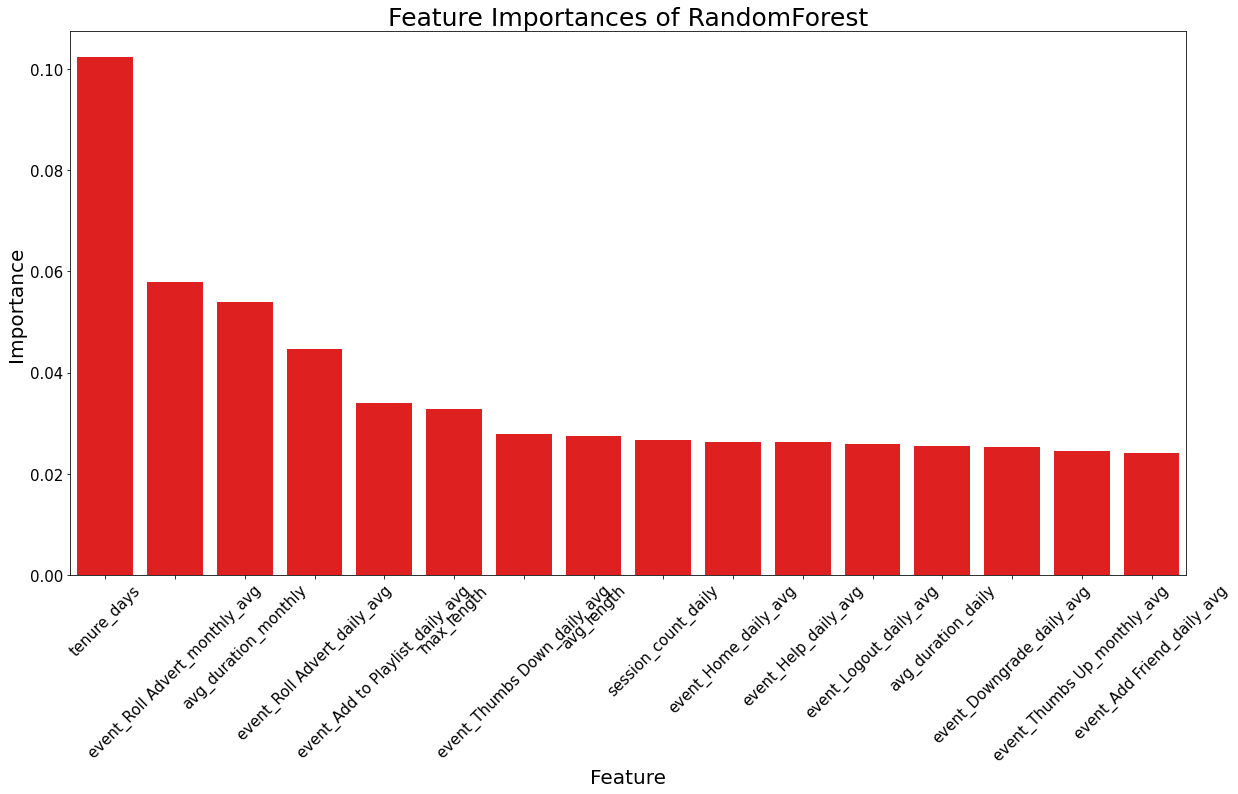

In [49]:
feat_importance = pd.DataFrame(list(zip(columns_ordered,best_model.stages[0].featureImportances)), 
                               columns= ["Feature","Importance"])

plt.figure(figsize = (20,10))

plt.title("Feature Importances of RandomForest")
sns.barplot(x="Feature", y="Importance", data=feat_importance.sort_values(by="Importance", ascending=False).iloc[:16], color="red")
plt.xticks(rotation=45);

After Tuning step, F1 score of the Random Forest decreased but the results are more confident than the first results.

Finally:

- I predicted churners with 0.82 F1 Score
- Best parameters : max depth:10, num Trees:20
- Tenure Days which is created in feature engineering step is the most important feature in the model
- Also daily and monthly averages of the event_ attributes have important part in my model

# Conclusion

As a result we created a churn model with 0.82 F1 Score. We know that the churn rate is around 20% (Let's assume 30%). If we take churn actions to every customer:
- precision will be nearly 0.3 (TP/(TP+FP))
- recall will be 1 (TP/(TP+FN))
- F1 Score will be nearly 0.46 ~ 0.5

If we assume these scores as base, our last models f1 score is 0.82. It is better than the base model. Also our model predicted nearly all churners correctly, it means that we can take action to the all potential churners.

## Reflection

This is my first project in Cloud side. It is hard to learn the syntax and some operations in dataset. Because I felt more confident and safe in pandas but Pandas is not enough for huge dataset. Also churn problem is my favorite problem because everyday I'm trying to solve problems about the churner subscribers in my professional life.

## Improvement

It is the small dataset for spark maybe larger dataset can help to identify churner subscribers more accurately. On the other hand more domain knowledge provides huge improvements to the results.